### ATR = American Time Range Strategy

In [1]:
import pandas as pd
from datetime import datetime, timedelta

def get_us_summer_time(year):
    march_first = datetime(year, 3, 1)
    second_sunday_march = march_first + timedelta(days=(6 - march_first.weekday() + 7) % 7 + 7)
    november_first = datetime(year, 11, 1)
    first_sunday_november = november_first + timedelta(days=(6 - november_first.weekday()) % 7)
    return [pd.to_datetime(second_sunday_march), pd.to_datetime(first_sunday_november)]

years = range(2015, 2025)
summer_times_us = {str(year): get_us_summer_time(year) for year in years}

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
os.chdir("../data")

In [3]:
file = "US100_M5_20230101_20240719"
file_us100_m5 = "US100_M5_20230101_20240720"

### CSV to parquet

In [4]:
summerTime = {
    "2023": [pd.to_datetime('2023-03-12'), pd.to_datetime("2023-11-05")],
    '2024': [pd.to_datetime('2024-03-26'), pd.to_datetime("2024-10-29")]
}
def check_summer_time(row):
    start, end = summer_times_us[row['year']]
    return True if end >= row['da'] >= start else False 

df = pd.read_csv(f'{file_us100_m5}.csv', sep="\t")
df.columns = ["da", "time", "op", "hi", "lo", "cl", "tickvol", "vol", "spread"]
df.da = pd.to_datetime(df.da.apply(lambda x: x.replace('.', '-')))
df.sort_values(by=['da', 'time'], ascending=True, inplace=True)
df['year'] = df['da'].apply(lambda x: x.strftime("%Y"))
df['summerTime'] = df.apply(check_summer_time, axis=1)

df.to_parquet(f"{file}.parquet")

FileNotFoundError: [Errno 2] No such file or directory: 'US100_M5_20230101_20240720.csv'

======

In [5]:
pq = pd.read_parquet(f"{file_us100_m5}.parquet")
df = pq.copy()#.loc[pq['da'] >= '2024-01-01']
df['signal'] = 0
df['trade_type'] = None
df['pct_change_open'] = df['op'].pct_change().shift(-1)
df['pt_diff_open'] = -df['op'].shift(0) + df['op'].shift(-1)

In [16]:
def strategy_open_1m_reversal(df, sep, us_open, daily_open):
    before_us_df = us_open - daily_open > 0
    df.loc[df['time'] == sep, 'signal'] = 1 if before_us_df else -1
    df.loc[df['time'] == sep.replace("30", "25"), 'trade_type'] = "open_1m"
    return df

def strategy_open_30m_trend(df, sep, hour, us_open):
    tp = 1000
    sl = 500
    pt = 0.001
    tp_price = tp*pt
    sl_price = sl*pt
    df_10 = df[df['time'] >= f"{hour+1}:00:00"]
    open_price_10 = df_10['op'].iloc[0]
    us_open_30 = (open_price_10 - us_open) > 0
    signal = 0
    open_position_price = 0
    close_position_price = 0
    # long
    if not us_open_30:
        upper_breakout = df[(df['time'] < f"{hour+1}:00:00") & (df['time'] >= sep)]['hi'].max()
        for _, row in df_10.iterrows():
            time = row['time']
            # breakout
            if row['cl'] > upper_breakout and signal == 0:
                open_position_price = row['cl']
                signal = 1
                df.loc[(df['time'] == time), "signal"] = signal
                sl = open_position_price - sl_price
                tp = open_position_price + tp_price
            # positionsTotal() == 1
            elif signal == 1:
                # tp
                if row['cl'] >= tp or row['cl'] <= sl:
                    df.loc[(df['time'] == time), "signal"] = 0
                    close_position_price = row['cl']
                    profit = close_position_price - open_position_price
                    signal = -1
                # nothing
                else:
                    df.loc[(df['time'] == time), "signal"] = 1
                # sl
                ##########
            # position closed
            elif signal == -1:
                return df
            # no position yet, no signal at the time
            else:
                continue
    # short case
    else:
        lower_breakout = df[(df['time'] < f"{hour+1}:00:00") & (df['time'] >= sep)]['cl'].min()
        for _, row in df_10.iterrows():
            time = row['time']
            # breakout
            if row['cl'] < lower_breakout and signal == 0:
                open_position_price = row['cl']
                signal = -1
                df.loc[(df['time'] == time), "signal"] = signal
                df.loc[(df['time'] == time), 'trade_type'] = "open_30m"
                tp = open_position_price - tp_price
                sl = open_position_price + sl_price
            # positionsTotal() == 1
            elif signal == -1:
                # tp/sl
                if row['cl'] <= tp or row['cl'] >= sl:
                    df.loc[(df['time'] == time), "signal"] = 0 # "close" for check purpose
                    
                    close_position_price = row['cl']
                    profit = -(close_position_price - open_position_price)
                    signal = 1
                # nothing
                else:
                    df.loc[(df['time'] == time), "signal"] = signal
                    df.loc[(df['time'] == time), 'trade_type'] = "open_30m"
                # sl
                ##########
            # position closed
            elif signal == 1:
                df.loc[(df['time'] == time), "signal"] = 0 # "close"for check purpose
                return df
            # no position yet, no signal at the time
            else:
                continue
    return df
def intraday_create_signal(df: pd.DataFrame):
    hour = 16 if df['summerTime'].iloc[0] else 17
    sep = f"{hour}:30:00"
    try:
        us_open = df[df['time'] == sep]['op'].values[0]
        daily_open = df.iloc[0, :]['op']
        
        df = strategy_open_1m_reversal(df, sep, us_open, daily_open)
        # df = strategy_open_30m_trend(df, sep, hour, us_open)
        return df
    except IndexError as e:
        return df

In [17]:
from tqdm import tqdm
tqdm.pandas()
df_out = df.groupby('da').progress_apply(intraday_create_signal)
df_out['signal'] = df_out['signal'].shift(1)
df_out[df_out['signal'] != 0]
df_out['interval_return'] = df_out['signal'] * df_out['pct_change_open']

100%|██████████| 370/370 [00:00<00:00, 1933.21it/s]


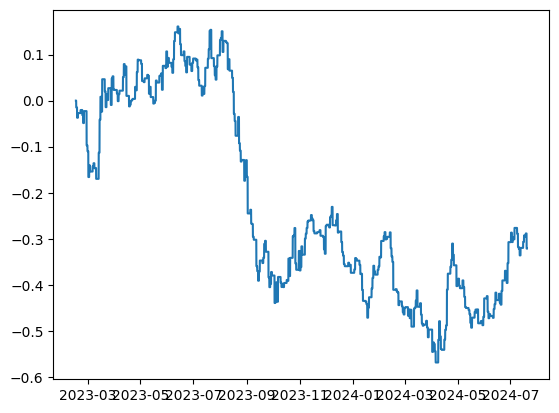

In [18]:
df_out['datetime'] = pd.to_datetime(df_out.index.get_level_values('da').astype(str) + ' ' + df_out['time'])
plt.plot(df_out['datetime'], ((1+df_out['interval_return']).cumprod()-1)*20)
# df_out['datetime']